<a href="https://colab.research.google.com/github/abbbe/autoenc/blob/main/robot-arm-vae2-double.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Monday 1/03/2021

* Train the autoencoder (double lane version) on 100k dataset
* Save the models 'autoencoder-double100k*.h5'
* Play with the slider

In [21]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import tensorflow as tf
import tensorflow.keras as kraes
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model, layers
%load_ext tensorboard

import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Load 100k dataset and visualize it

In [22]:
with open('dataset-random-100k.pickle', 'rb') as handle:
    [train_A, train_Y, test_A, test_Y, val_A, val_Y] = pickle.load(handle)
print(train_Y.shape)

(100000, 64, 64, 1)


In [259]:
def _clean_ax(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
def _imshow(ax, img):
    if img is not None:
        ax.imshow(img, cmap='Greys', origin='lower')
    _clean_ax(ax)
        
def plot_Y(img_array):
    assert(img_array.shape[-1] == 1)
    fig, axs = plt.subplots(figsize=(2, 2))
    _imshow(axs, img_array[..., 0])
    return fig, axs

def plot_Ys(img_array, title=None, ncols=5):
    assert(ncols > 0)

    nimgs = img_array.shape[0]
    if nimgs == 0:
        return None, None
    elif nimgs == 1:
        return plot_Y(img_array[0,...])
    elif nimgs <= ncols:
        ncols = nimgs
        fig, axs = plt.subplots(1, ncols, figsize=(2*ncols, 2))

        for i in range(ncols):
            _imshow(axs[i], img_array[i,...])
    else:
        nrows = int((nimgs-1)/ ncols) + 1
        fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))

        for i in range(nrows):
            for j in range(ncols):
                k = i*ncols + j
                if k < nimgs:
                    img = img_array[k,...]
                else:
                    img = None
                _imshow(axs[i][j], img)
                    
    if title is not None:
        fig.suptitle("%s (%s)" % (title, str(img_array.shape)))
        
    return fig, axs

In [248]:
#_=plot_Y(train_Y[0,...])
#_=plot_Ys(train_Y[0:1,...])
#_=plot_Ys(train_Y[0:5,...])
#_=plot_Ys(train_Y[0:6,...])
#_=plot_Ys(train_Y[0:24,...])

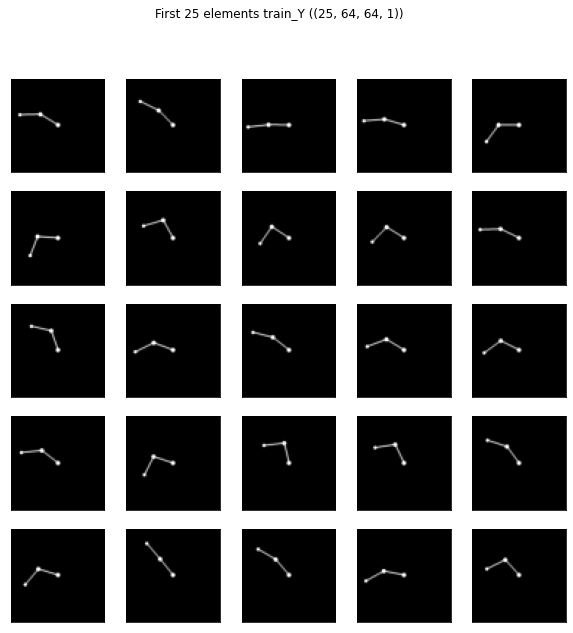

In [249]:
_=plot_Ys(train_Y[0:25,...], title="First 25 elements train_Y")

## Build the model and fit it

In [39]:
from model import build_conv_autoencoder

autoencoder, encoder, decoder = build_conv_autoencoder(train_Y.shape[1:], 2)

In [40]:
def train_model():
    import os, datetime
    logdir = os.path.join("logs-train-100k-202103011834/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir) #, histogram_freq=1)
    
    autoencoder.fit(train_Y, train_Y, epochs=50, validation_data=(test_Y, test_Y), verbose=1,
                    callbacks=[tensorboard_callback])

In [ ]:
for _ in range(4):
    train_model()

```Train on 100000 samples, validate on 100 samples
Epoch 1/50
100000/100000 [==============================] - 31s 314us/sample - loss: 0.0012 - val_loss: 9.5710e-04
Epoch 2/50
100000/100000 [==============================] - 30s 301us/sample - loss: 9.1501e-04 - val_loss: 9.3199e-04
Epoch 3/50
100000/100000 [==============================] - 30s 301us/sample - loss: 8.8385e-04 - val_loss: 9.1264e-04
Epoch 4/50
100000/100000 [==============================] - 30s 302us/sample - loss: 8.6931e-04 - val_loss: 9.1007e-04
Epoch 5/50
100000/100000 [==============================] - 30s 302us/sample - loss: 8.5161e-04 - val_loss: 9.2882e-04
...
100000/100000 [==============================] - 29s 290us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 47/50
100000/100000 [==============================] - 29s 294us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 48/50
100000/100000 [==============================] - 30s 301us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 49/50
100000/100000 [==============================] - 30s 301us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 50/50
100000/100000 [==============================] - 30s 301us/sample - loss: 0.0011 - val_loss: 0.0011
Train on 100000 samples, validate on 100 samples
Epoch 1/50
100000/100000 [==============================] - 30s 300us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 2/50
 73824/100000 [=====================>........] - ETA: 7s - loss: 0.0011
```

*No changes for tens of epochs, interrrupted.*

In [140]:
%load_ext tensorboard
%tensorboard --logdir logs-train-100k-202103011834/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16140), started 0:00:46 ago. (Use '!kill 16140' to kill it.)

*Something bad happened after the first fit().
When second fit() starts, loss goes up from 7.5e-4 up to 1e-3 and never falls*

## Assess performance on training, test, and validation sets

In [264]:
def cycle_autoencoder(data, prefix="", N=25):
    Y = data['Y']
    
    print("Y.shape=" + str(Y.shape))
    L = encoder.predict(Y)
    L = np.array(L)
    print("L.shape=" + str(L.shape))
    YY = decoder.predict([train_L[0], train_L[1]])
    YY = np.array(YY)
    print("YY.shape=" + str(YY.shape))
    
    data['L'] = L
    data['YY'] = YY

    # - Y
    plot_Ys(Y[0:25,...], title="First %d elements of %sY" % (N, prefix))

    # - L
    fig, axs = plt.subplots(1, L.shape[0])
    fig.suptitle("Latent variables %s" % (str(L.shape)))
    for i in range(L.shape[0]):
        axs[i].hist(L[i,:])    
    
    # - YY
    plot_Ys(YY[0:N,...], title="First %d elements of %sYY" % (N, prefix))
        
    return data

Y.shape=(100000, 64, 64, 1)
L.shape=(2, 100000, 1)
YY.shape=(100000, 64, 64, 1)


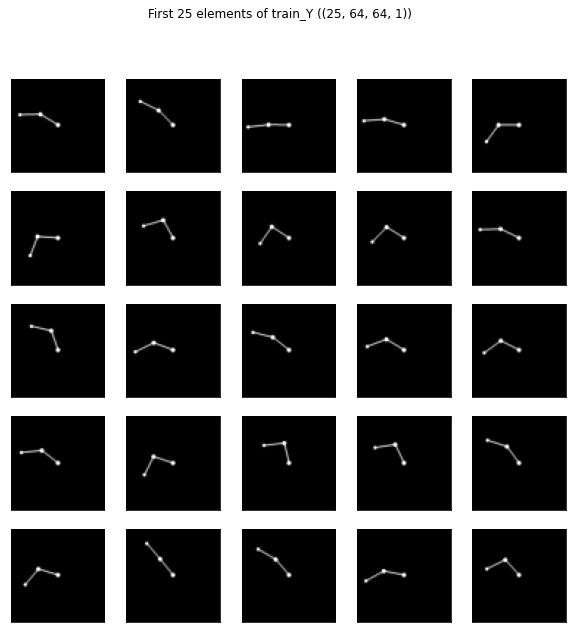

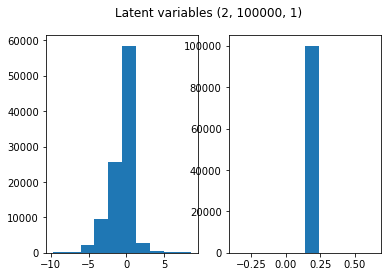

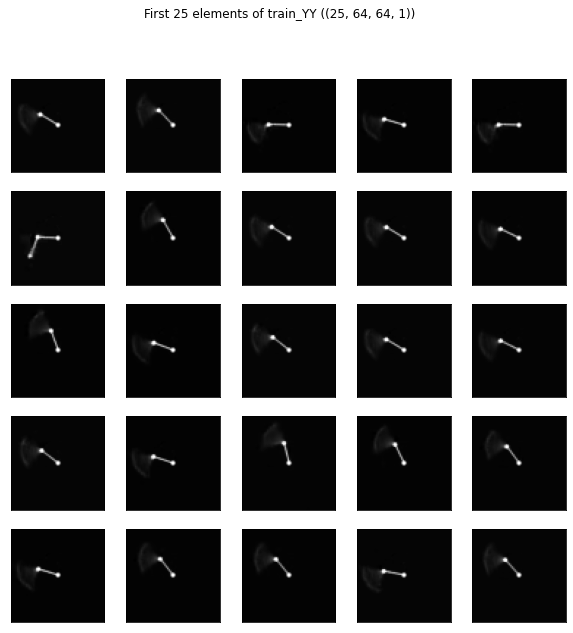

In [265]:
train = cycle_autoencoder({'Y': train_Y}, prefix="train_")

## The same for test dataset

Y.shape=(100, 64, 64, 1)
L.shape=(2, 100, 1)
YY.shape=(100000, 64, 64, 1)


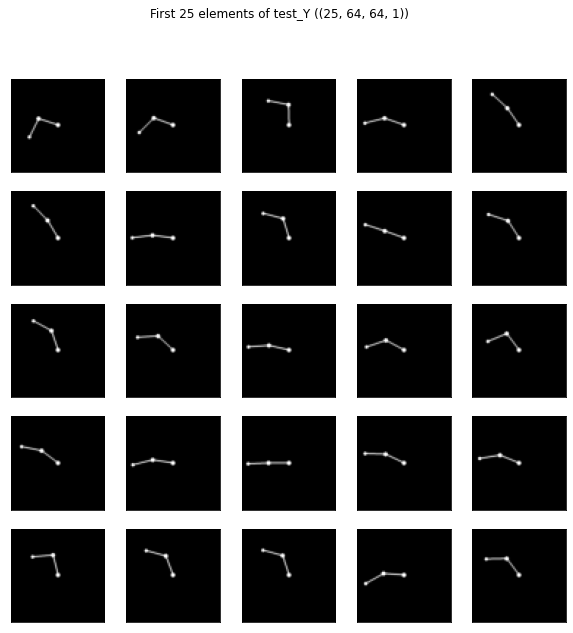

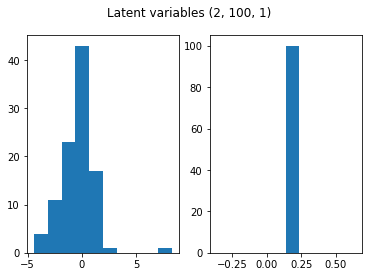

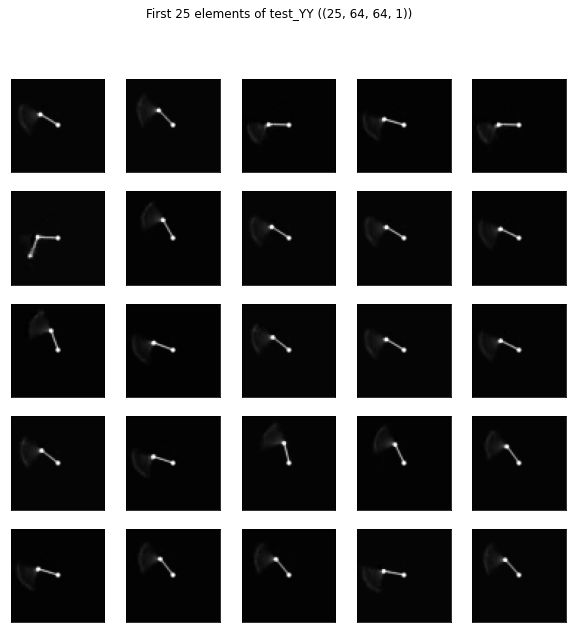

In [266]:
test = cycle_autoencoder({'Y': test_Y}, prefix="test_")

## The same for validation dataset

In [267]:
val_A, val_Y = gen_data(100)

Generating 100 datapoints ... (approx 3.500000 sec)
Generated 100 data points. Actual time: 3.2s (0.032264 sec/datapoint)


Y.shape=(100, 64, 64, 1)
L.shape=(2, 100, 1)
YY.shape=(100000, 64, 64, 1)


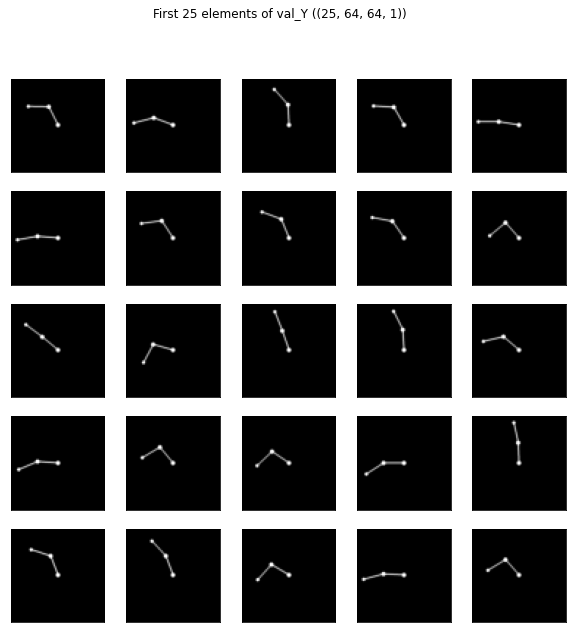

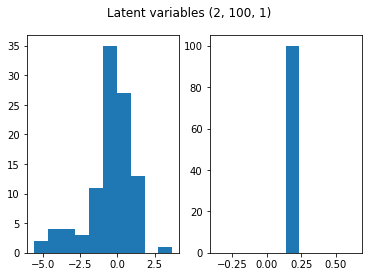

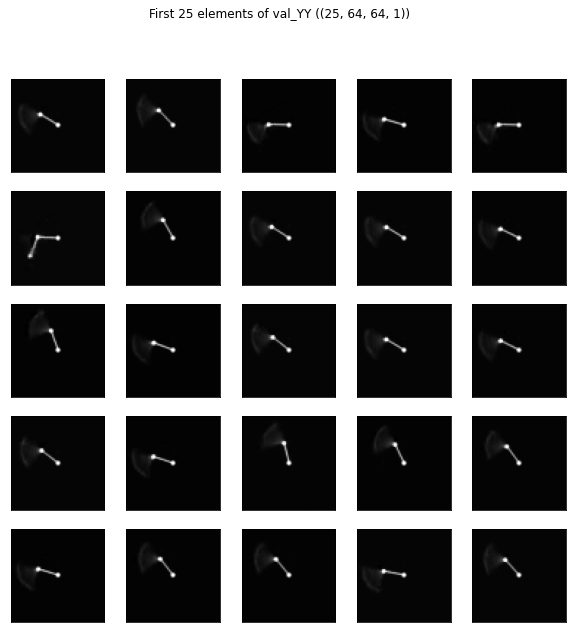

In [268]:
val = cycle_autoencoder({'Y': val_Y}, prefix="val_")

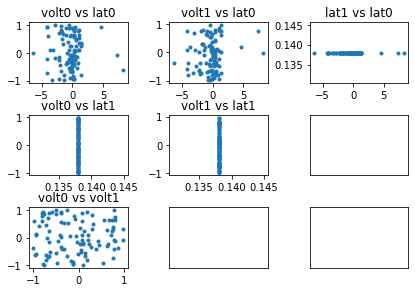

In [269]:
# plot the latent vars (vertical axis) vs joints (horizontal)
nLat = val_L.shape[0]
nVoltages = val_A.shape[1]

fig, axs = plt.subplots(nLat+1, nVoltages+1)
fig.tight_layout()

for i in range(nLat):
  for j in range(nVoltages):
    title = "volt%d vs lat%d" % (j, i)
    axs[i][j].title.set_text(title)
    axs[i][j].plot(val_L[i, :], val_A[:,j], '.')

axs[nLat][0].title.set_text("volt0 vs volt1")
axs[nLat][0].plot(val_A[:,1], val_A[:,0], '.')

axs[0][nVoltages].title.set_text("lat1 vs lat0")
axs[0][nVoltages].plot(val_L[0,:], val_L[1,:], '.')

_clean_ax(axs[1][2])
_clean_ax(axs[2][1])
_clean_ax(axs[2][2])

In [123]:
def save_models(prefix):
    autoencoder.save(prefix + '-ae.h5')
    encoder.save(prefix + '-enc.h5')
    decoder.save(prefix + '-dec.h5')
    print("Models saved to " + prefix + " ...")

## Change latent variables and render live decoder output

In [262]:
import ipywidgets as widgets
from IPython.display import display

slider0 = widgets.FloatSlider(value=0.0, min=-25, max=25, step=0.01)
slider1 = widgets.FloatSlider(value=0.0, min=-5, max=5, step=0.01)
#button = widgets.Button(description="Redraw")
output = widgets.Output()
 
def redraw(_=None):
    with output:
        output.clear_output(wait=True)
        #print("# %f %f" % (slider0.value, slider1.value))
        
        L = [np.array([[slider0.value]]), np.array([[slider1.value]])]
        Ys = decoder.predict(L)[0,...,0]

        plt.clf()
        plt.imshow(Ys, cmap='Greys')
        plt.show()

slider0.observe(redraw, names='value')
slider1.observe(redraw, names='value')

#button.on_click(redraw)
#display(button, output)
display(output, slider0, slider1)
redraw()

Output()

FloatSlider(value=0.0, max=25.0, min=-25.0, step=0.01)

FloatSlider(value=0.0, max=5.0, min=-5.0, step=0.01)

TODO !!!!

## Save the data and the models

In [124]:
save_models("autoencoder-double100k")

Models saved to autoencoder-double100k ...
